# Dropout, функции активации и PyTorch-сеть для предсказания пороков сердца

---

## Что вы изучите сегодня
### 1) Dropout (регуляризация)
- зачем нужен Dropout
- почему он работает только в `model.train()`
- как выбирать `p` (например 0.1–0.5)

### 2) Нейросеть на PyTorch (минимальный пайплайн)
- DataFrame → numpy → torch.Tensor
- Dataset + DataLoader
- модель → loss → optimizer → обучение
- оценка качества (accuracy + confusion matrix + F1)

### 3) Функции активации и проблемы градиентов
- для выхода: **Sigmoid**, **Softmax**
- для скрытых: **Sigmoid**, **tanh**, **ReLU**, **LeakyReLU**, **Swish**
- “вымывание градиента” (vanishing)
- “взрыв градиента” (exploding)
- простые решения

### 4) Кейс: предсказание “пороков сердца” (binary classification)
- сгенерируем маленький учебный датасет (похож на медицинские признаки)
- построим сеть и сравним **без Dropout vs с Dropout**
- сохраним модель и загрузим обратно

In [4]:
# Если библиотек нет (обычно в Colab всё есть):
# !pip install torch scikit-learn pandas matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("torch:", torch.__version__)

device: cpu
torch: 2.9.1+cpu


# 1) Dropout регуляризация — что это?

## Идея
Dropout — это техника, которая **случайно “выключает” часть нейронов** во время обучения.

Если `p=0.3`, это означает:
- примерно **30% активаций зануляются**
- модель не может “надеяться” на один конкретный нейрон
- она учится распределять знания по сети

## Почему это снижает переобучение?
Переобучение = модель “запомнила train”, но плохо работает на новых данных.

Dropout заставляет сеть быть “устойчивой”:
- как будто мы обучаем много “слегка отличающихся сетей”
- и потом усредняем их поведение

## Очень важное правило
- `model.train()` → Dropout **включён**
- `model.eval()` → Dropout **выключен** (всё работает стабильно)

## Типичные значения
- 0.1–0.2: лёгкая регуляризация
- 0.3–0.5: сильнее, если модель переобучается


In [5]:
# Мини-демо: Dropout в train и eval режимах
drop = nn.Dropout(p=0.5)

x = torch.ones(10)  # десять единиц
print("input:", x)

drop.train()
print("train mode dropout:", drop(x))

drop.eval()
print("eval mode dropout :", drop(x))

input: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
train mode dropout: tensor([2., 2., 2., 2., 0., 2., 0., 0., 2., 2.])
eval mode dropout : tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


# 2) Функции активации — зачем они нужны?

Без активаций нейросеть была бы просто “линейной”:
- Linear → Linear → Linear = всё равно Linear  
то есть сеть не могла бы учить сложные зависимости.

**Функция активации делает модель нелинейной.**

---

## Активации для выходного слоя
### Sigmoid (binary classification)
- превращает число (logit) в вероятность 0..1

### Softmax (multi-class classification)
- превращает logits в вероятности, сумма = 1

---

## Активации для скрытых слоёв
- Sigmoid — часто даёт вымывание градиента (плохая для глубоких сетей)
- tanh — лучше sigmoid, но тоже может “насыщаться”
- ReLU — очень популярная, быстро учится
- LeakyReLU — версия ReLU, чтобы избежать “мертвых нейронов”
- Swish — плавная современная (часто хорошо работает)


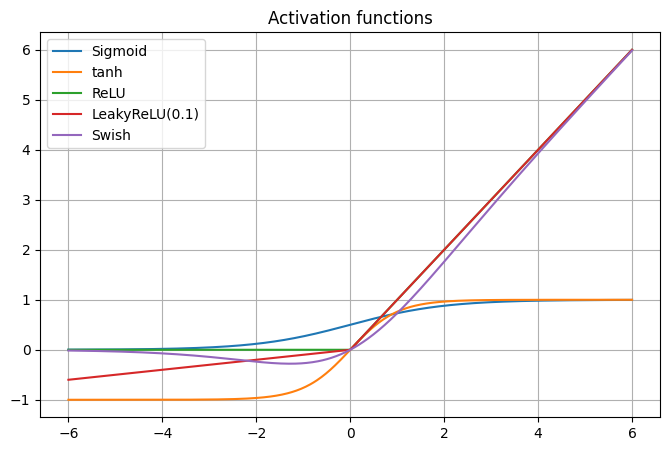

In [6]:
# Графики активаций (очень наглядно)
x = np.linspace(-6, 6, 500)

sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)
relu = np.maximum(0, x)
leaky_relu = np.where(x > 0, x, 0.1 * x)
swish = x * (1 / (1 + np.exp(-x)))  # x * sigmoid(x)

plt.figure(figsize=(8,5))
plt.plot(x, sigmoid, label="Sigmoid")
plt.plot(x, tanh, label="tanh")
plt.plot(x, relu, label="ReLU")
plt.plot(x, leaky_relu, label="LeakyReLU(0.1)")
plt.plot(x, swish, label="Swish")
plt.title("Activation functions")
plt.grid(True)
plt.legend()
plt.show()

# 3) Вымывание и взрыв градиента

## Vanishing gradients
Градиенты становятся **очень маленькими** → сеть почти не учится.

Часто бывает из-за:
- sigmoid/tanh в глубоких сетях (насыщение)
- много слоёв подряд

Решения (база):
- ReLU/LeakyReLU в скрытых слоях
- нормализация входов
- BatchNorm (позже)
- хорошая инициализация

## Exploding gradients
Градиенты становятся **слишком большими** → loss скачет → NaN.

Решения (база):
- уменьшить learning rate
- gradient clipping


In [7]:
# Gradient clipping (памятка)
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

print("Gradient clipping — это ограничение нормы градиента, чтобы обучение не ломалось.")

Gradient clipping — это ограничение нормы градиента, чтобы обучение не ломалось.


# 4) Учебный датасет “пороки сердца”

Чтобы не возиться с файлами, генерируем небольшой датасет, похожий на медицинские признаки.

Цель `target`:
- 1 → риск/наличие проблемы
- 0 → нет

> Учебный пример, не медицинский.


In [8]:
# Генерация учебного датасета
N = 1400

age = np.random.randint(29, 78, size=N)
sex = np.random.randint(0, 2, size=N)  # 0/1
chol = np.random.normal(220, 35, size=N).clip(120, 380)
bp = np.random.normal(130, 18, size=N).clip(90, 200)
max_hr = np.random.normal(150, 22, size=N).clip(80, 210)
glucose = np.random.normal(100, 20, size=N).clip(60, 220)
chest_pain = np.random.randint(0, 4, size=N)  # 0..3
smoker = (np.random.rand(N) < 0.28).astype(int)
bmi = np.random.normal(26.5, 4.2, size=N).clip(16, 45)
stress = np.random.randint(0, 11, size=N)  # 0..10

logit = (
    0.04*(age-50) +
    0.015*(chol-200) +
    0.02*(bp-120) -
    0.015*(max_hr-150) +
    0.02*(glucose-95) +
    0.35*smoker +
    0.08*(bmi-25) +
    0.10*(stress-5) +
    0.18*(chest_pain) +
    0.10*sex
)
prob = 1 / (1 + np.exp(-logit))
target = (np.random.rand(N) < prob).astype(int)

df = pd.DataFrame({
    "age": age,
    "sex": sex,
    "cholesterol": chol,
    "systolic_bp": bp,
    "max_hr": max_hr,
    "glucose": glucose,
    "chest_pain": chest_pain,
    "smoker": smoker,
    "bmi": bmi,
    "stress": stress,
    "target": target
})
df.head()


,age,sex,cholesterol,systolic_bp,max_hr,glucose,chest_pain,smoker,bmi,stress,target
0,67,0,181.769053,134.687961,116.173134,92.532631,0,0,26.841364,5,0
1,57,1,208.925704,120.300847,146.812099,89.996044,0,0,31.451142,3,0
2,43,0,262.458419,111.846016,140.189238,96.602953,3,0,24.672676,3,1
3,71,0,224.960092,94.672738,152.489090,132.734799,3,0,25.190961,3,1
4,36,0,301.176534,136.293701,142.011433,96.333986,3,0,20.918168,9,0


In [9]:
# Быстрый взгляд на статистику
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,1400.0,53.124286,14.159017,29.000000,41.000000,54.000000,65.000000,77.000000
sex,1400.0,0.497857,0.500174,0.000000,0.000000,0.000000,1.000000,1.000000
cholesterol,1400.0,221.097080,34.359062,120.000000,197.708773,220.707181,243.882995,331.758765
systolic_bp,1400.0,129.800311,18.143395,90.000000,117.073349,129.519767,141.556533,200.000000
max_hr,1400.0,149.043708,21.574175,80.112516,134.997238,149.491055,163.998754,210.000000
glucose,1400.0,99.474388,20.093581,60.000000,85.092773,99.088169,113.642213,161.965989
chest_pain,1400.0,1.529286,1.134550,0.000000,1.000000,2.000000,3.000000,3.000000
smoker,1400.0,0.280000,0.449159,0.000000,0.000000,0.000000,1.000000,1.000000
bmi,1400.0,26.532797,4.026740,16.000000,23.895687,26.595455,29.201521,39.762639
stress,1400.0,4.922857,3.169691,0.000000,2.000000,5.000000,8.000000,10.000000


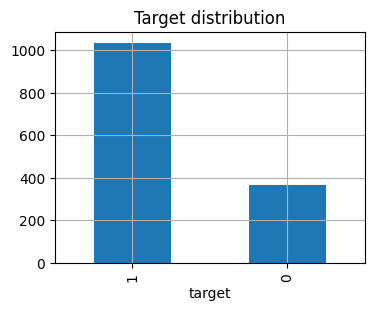

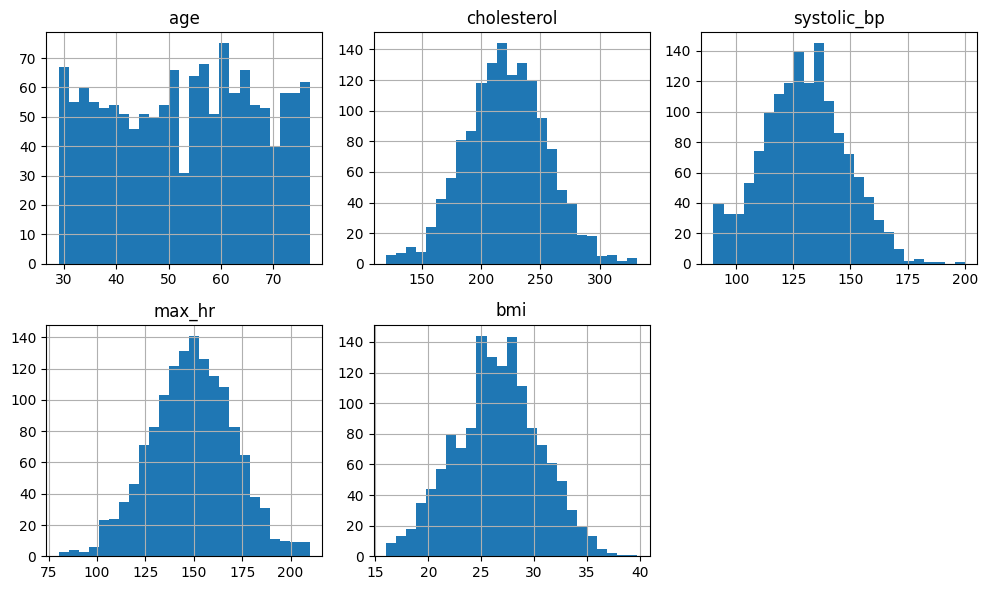

In [10]:
# Мини-EDA
plt.figure(figsize=(4,3))
df["target"].value_counts().plot(kind="bar")
plt.title("Target distribution")
plt.grid(True)
plt.show()

cols = ["age", "cholesterol", "systolic_bp", "max_hr", "bmi"]
plt.figure(figsize=(10,6))
for i, c in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[c], bins=25)
    plt.title(c)
    plt.grid(True)
plt.tight_layout()
plt.show()


# 5) Подготовка данных (preprocessing)

1) X/y  
2) train/test split  
3) StandardScaler (fit на train)  
4) torch.Tensor + reshape y -> (n,1)  
5) DataLoader  


In [11]:
TARGET_COL = "target"
X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

xb, yb = next(iter(train_loader))
print("batch X:", xb.shape, xb.dtype)
print("batch y:", yb.shape, yb.dtype)


batch X: torch.Size([64, 10]) torch.float32
batch y: torch.Size([64, 1]) torch.float32


# 6) Нейросеть для бинарной классификации + Dropout

Выход: **1 logit**  
Loss: **BCEWithLogitsLoss** (сигмоида внутри)

Сделаем:
- без Dropout
- с Dropout (0.3)


In [12]:
class HeartNet(nn.Module):
    def __init__(self, n_in, hidden=32, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(n_in, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        logits = self.fc3(x)
        return logits

n_features = X_train_t.shape[1]
model_no_drop = HeartNet(n_in=n_features, hidden=32, dropout=0.0).to(device)
model_drop    = HeartNet(n_in=n_features, hidden=32, dropout=0.3).to(device)

print("params:", sum(p.numel() for p in model_drop.parameters()))

params: 1441


# 7) Train/Eval

Предсказание класса:
- logits -> sigmoid -> probability
- probability >= threshold -> 1 иначе 0


In [13]:
criterion = nn.BCEWithLogitsLoss()

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device, threshold=0.5):
    model.eval()
    probs_all, y_all = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        probs_all.append(probs)
        y_all.append(yb.numpy().reshape(-1))

    probs = np.concatenate(probs_all)
    y_true = np.concatenate(y_all).astype(int)
    y_pred = (probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, probs, y_true, y_pred

In [14]:
def fit_model(model, train_loader, test_loader, epochs=15, lr=1e-3, threshold=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []

    for epoch in range(1, epochs+1):
        loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        acc, f1, cm, *_ = evaluate(model, test_loader, device, threshold=threshold)
        history.append((epoch, loss, acc, f1))
        if epoch % 5 == 0:
            print(f"epoch={epoch:02d} loss={loss:.4f} acc={acc:.4f} f1={f1:.4f}")

    return pd.DataFrame(history, columns=["epoch","loss","acc","f1"])

# 8) Baseline: без Dropout

In [15]:
hist_no = fit_model(model_no_drop, train_loader, test_loader, epochs=15, lr=1e-3)
hist_no.tail()

epoch=05 loss=0.5285 acc=0.7393 f1=0.8501
epoch=10 loss=0.4823 acc=0.7571 f1=0.8547
epoch=15 loss=0.4699 acc=0.7679 f1=0.8596


,epoch,loss,acc,f1
10,11,0.479241,0.760714,0.855914
11,12,0.477400,0.757143,0.854701
12,13,0.473567,0.767857,0.859002
13,14,0.471640,0.771429,0.860870
14,15,0.469877,0.767857,0.859611


In [16]:
acc, f1, cm, probs, y_true, y_pred = evaluate(model_no_drop, test_loader, device, threshold=0.5)
print("No Dropout -> acc:", acc, "f1:", f1)
print("CM:\n", cm)
print("Report:\n", classification_report(y_true, y_pred, digits=3))

No Dropout -> acc: 0.7678571428571429 f1: 0.8596112311015118
CM:
 [[ 16  57]
 [  8 199]]
Report:
               precision    recall  f1-score   support

           0      0.667     0.219     0.330        73
           1      0.777     0.961     0.860       207

    accuracy                          0.768       280
   macro avg      0.722     0.590     0.595       280
weighted avg      0.748     0.768     0.722       280



# 9) С Dropout и сравнение

In [17]:
hist_drop = fit_model(model_drop, train_loader, test_loader, epochs=15, lr=1e-3)
hist_drop.tail()


epoch=05 loss=0.5546 acc=0.7393 f1=0.8501
epoch=10 loss=0.5085 acc=0.7429 f1=0.8512
epoch=15 loss=0.4933 acc=0.7571 f1=0.8528


,epoch,loss,acc,f1
10,11,0.498993,0.750000,0.854772
11,12,0.502102,0.760714,0.859539
12,13,0.503048,0.757143,0.857143
13,14,0.494216,0.767857,0.861996
14,15,0.493260,0.757143,0.852814


In [18]:
acc2, f12, cm2, *_ = evaluate(model_drop, test_loader, device, threshold=0.5)
print("Dropout -> acc:", acc2, "f1:", f12)
print("CM:\n", cm2)


Dropout -> acc: 0.7571428571428571 f1: 0.8528138528138528
CM:
 [[ 15  58]
 [ 10 197]]


In [19]:
# Порог
for thr in [0.3, 0.5, 0.7]:
    acc_thr, f1_thr, cm_thr, *_ = evaluate(model_drop, test_loader, device, threshold=thr)
    print(f"thr={thr} -> acc={acc_thr:.4f}, f1={f1_thr:.4f}, CM={cm_thr.tolist()}")


thr=0.3 -> acc=0.7393, f1=0.8501, CM=[[0, 73], [0, 207]]
thr=0.5 -> acc=0.7571, f1=0.8528, CM=[[15, 58], [10, 197]]
thr=0.7 -> acc=0.7321, f1=0.8082, CM=[[47, 26], [49, 158]]


# 10) Save/Load модели

In [1]:
MODEL_PATH = "heartnet_state_dict.pt"
torch.save(model_drop.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

model_loaded = HeartNet(n_in=n_features, hidden=32, dropout=0.3).to(device)
model_loaded.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model_loaded.eval()

accL, f1L, cmL, *_ = evaluate(model_loaded, test_loader, device, threshold=0.5)
print("Loaded -> acc:", accL, "f1:", f1L)
print("CM:\n", cmL)


NameError: name 'torch' is not defined

---
# 10 задач на закрепление (дополнить код)
**Формат:** задание → подсказка → код с пропусками `_____`.


## Задание 1

**Задание:** Постройте графики: sigmoid, tanh, relu.

**Подсказка:** np.linspace, np.tanh, np.maximum


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-6, 6, 400)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)
relu = np.maximum(0, x)

plt.figure(figsize=(7,4))
plt.plot(x, sigmoid, label="sigmoid")
plt.plot(x, tanh, label="tanh")
plt.plot(x, relu, label="relu")
plt.grid(True)
plt.legend()
plt.show()

## Задание 2

**Задание:** Dropout: покажите train vs eval.

**Подсказка:** drop.train(), drop.eval()


In [21]:
import torch
import torch.nn as nn

drop = nn.Dropout(p=0.5)
x = torch.ones(10)

drop.train()
print("train:", drop(x))

drop.eval()
print("eval :", drop(x))

train: tensor([2., 2., 0., 0., 2., 2., 2., 2., 2., 2.])
eval : tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Задание 3

**Задание:** train_test_split со stratify.

**Подсказка:** train_test_split(..., stratify=y)


In [22]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)

(1120, 10) (280, 10)


## Задание 4

**Задание:** StandardScaler: fit на train, transform на test.

**Подсказка:** fit_transform / transform


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((1120, 10), (280, 10))

## Задание 5

**Задание:** torch.Tensor + reshape y -> (n,1).

**Подсказка:** torch.tensor + reshape(-1,1)


In [24]:
import torch

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
print(X_train_t.shape, y_train_t.shape)

torch.Size([1120, 10]) torch.Size([1120, 1])


## Задание 6

**Задание:** TensorDataset + DataLoader.

**Подсказка:** TensorDataset(X,y) + DataLoader(...)


In [25]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)

torch.Size([16, 10]) torch.Size([16, 1])


## Задание 7

**Задание:** Допишите модель с Dropout и ReLU.

**Подсказка:** nn.Dropout, F.relu


In [29]:
import torch.nn as nn
import torch.nn.functional as F

class HeartNetStudent(nn.Module):
    def __init__(self, n_in, hidden=32, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(n_in, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        logits = self.fc3(x)
        return logits

m = HeartNetStudent(n_in=X_train_t.shape[1])
print(m)

HeartNetStudent(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)


## Задание 8

**Задание:** Один шаг обучения (BCEWithLogitsLoss + Adam).

**Подсказка:** zero_grad/backward/step


In [30]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HeartNetStudent(n_in=X_train_t.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device)

logits = model(xb)
loss = criterion(logits, yb)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print("loss:", loss.item())

loss: 0.7458512187004089


## Задание 9

**Задание:** predict: logits -> sigmoid -> threshold -> pred

**Подсказка:** torch.sigmoid


In [31]:
import torch
import numpy as np

model.eval()
with torch.no_grad():
    logits = model(xb)
    probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
    thr = 0.5
    y_pred = (probs >= thr).astype(int)

print("probs[:5]:", probs[:5])
print("pred[:5] :", y_pred[:5])

probs[:5]: [0.44063607 0.44165465 0.46507365 0.452378   0.47345397]
pred[:5] : [0 0 0 0 0]


## Задание 10

**Задание:** Сохраните state_dict и загрузите.

**Подсказка:** torch.save + load_state_dict


In [35]:
import torch

path = "tmp_heartnet.pt"
torch.save(model.state_dict(), path)

model2 = HeartNetStudent(n_in=X_train_t.shape[1]).to(device)
model2.load_state_dict(torch.load(path, map_location=device))
model2.eval()

print("loaded ok")

loaded ok
